In [121]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
import seaborn as sns

In [91]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [92]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Cod

In [93]:
M_order=3

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³"
ro3=1141  # Elastic sphere Density "kg/m³"
ro4=51.3  # Inner Gas Sphere Density "kg/m³"

c1=1480    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=325.1    # gas speed of sound "m/s"

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=0.17*1.0E6  # "N/m²" shear rigidity of elastic shell
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"
    
Delta=0.01*1E-3 # Swimbladder wall thickness
#R4=0.14*1E-3 #0.001  # (m) radius of gas sphere
#R3=R4+Delta  # (m) radius of elastic shell 
#R2=2*1E-3  # (m) radius till viscous layer
#R2=R4*( (1+(ro1-ro4)/(ro2-ro1))**(1/3) ) # Eq 18 in our JASA mesopelagic paper

In [94]:
# set fixed values
params_cod ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Variable Parameters
For these model simulations the only variable is the **SHAPE.**

The main variable parameter is R3- the radius of the swimbladder including the wall. In the case of Limacina it is the whole measured length (or calculated width).

The other two variable parameters are R4- radius of the swimbladder (R3-thickness of swimbladder wall) and R2-radius of fish fesh, since there is not flesh around the shell in a Limacina, we use R4=R3.

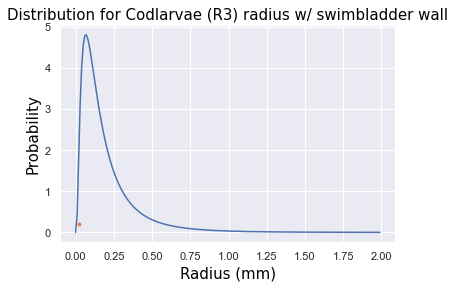

In [95]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# radius distribution was calculated using all measured lengths and their associated widths (L/a=1.5 Stanton 2000)
# For lognorm dist s = sigma, scale  = exp(mean)
x=np.arange(0,2,0.01)
R3_dist = stats.lognorm.pdf(x,s=0.86, scale = np.exp(-1.97))

plt.plot(x,R3_dist)
plt.plot(np.random.lognormal(mean=-1.97, sigma=0.86),0.2, '.')
plt.title('Distribution for Codlarvae (R3) radius w/ swimbladder wall', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

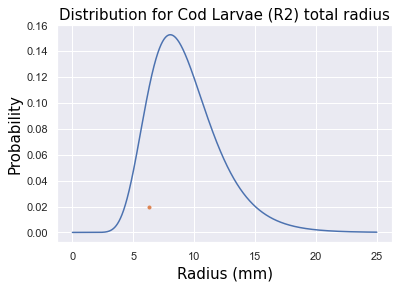

In [96]:
# Radius R2 distribution
# Values from lengthDist.Rmd.
# radius distribution was calculated using all measured lengths and their associated widths (L/a=1.5 Stanton 2000)
# For lognorm dist s = sigma, scale  = exp(mean)
x=np.arange(0,25,0.01)
R2_dist = stats.lognorm.pdf(x,s=0.31, scale = np.exp(2.18))

plt.plot(x,R2_dist)
plt.plot(np.random.lognormal(mean=2.18,sigma=0.31),0.02, '.')
plt.title('Distribution for Cod Larvae (R2) total radius', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

## Set up simulation

In [97]:
# Frequency range
min_freq=100*1000
max_freq=600*1000
frequencySpacing=500
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run ensembles

In [98]:
nsim = 1000
nfreqs = len(Freq_vec)

# Allocate space for speed
R2_ensemble = np.zeros((nsim,1))
R3_ensemble = np.zeros((nsim,1))
TS_simulations = np.zeros((nsim*nfreqs))
freqs=np.zeros((nsim*nfreqs))

for ind_sim in np.arange(nsim):
    
    # Set new radius parameters
    R2 = np.random.lognormal(mean=2.18,sigma=0.31)*1e-3
    R3 = np.random.lognormal(mean=2.18,sigma=0.31)*1e-3
    params_cod['R2'] = R2
    params_cod['R3'] = R3
    params_cod['R4'] = R3  - 0.01
    
    # Run the v-e model
    print('Running simulations for radius %.2f mm, simulation %.0f' %(R3*1000,ind_sim))
    TS_vec_cod = vefunc.run_ve(Freq_vec, M_order, params_cod)
    
    # Save each iterated radius values
    R2_ensemble[ind_sim] = R2
    R3_ensemble[ind_sim] = R3


    # Save all results.
    TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_cod
    freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for radius 13.17 mm, simulation 0
Running simulations for radius 11.03 mm, simulation 1
Running simulations for radius 8.01 mm, simulation 2
Running simulations for radius 9.74 mm, simulation 3
Running simulations for radius 4.58 mm, simulation 4
Running simulations for radius 7.99 mm, simulation 5
Running simulations for radius 10.83 mm, simulation 6
Running simulations for radius 9.98 mm, simulation 7
Running simulations for radius 9.03 mm, simulation 8
Running simulations for radius 11.54 mm, simulation 9
Running simulations for radius 11.33 mm, simulation 10
Running simulations for radius 6.13 mm, simulation 11
Running simulations for radius 16.77 mm, simulation 12


C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:283: RuntimeWarning: overflow encountered in cdouble_scalars
  M_Matrix[5,2]=(-1j*w)*2*Eta2*k_c2*R3*dh_func(m,k_c2*R3) - (-1j*w)*2*Eta2*h_func(m,k_c2*R3)
C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:273: RuntimeWarning: overflow encountered in cdouble_scalars
  M_Matrix[4,2]=(-1j*w)*Eta2*(2*k_c2*k_c2-k_s2sq)*R3*R3*h_func(m,k_c2*R3) + (-1j*w)*2*Eta2*k_c2*k_c2*R3*R3*ddh_func(m,k_c2*R3)
C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:273: RuntimeWarning: invalid value encountered in cdouble_scalars
  M_Matrix[4,2]=(-1j*w)*Eta2*(2*k_c2*k_c2-k_s2sq)*R3*R3*h_func(m,k_c2*R3) + (-1j*w)*2*Eta2*k_c2*k_c2*R3*R3*ddh_func(m,k_c2*R3)
C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:69: RuntimeWarning: invalid value encountered in cdouble_scalars
  elif (DerivativeOrder==2):
C:\Users\mbd\phd\ViscousElastic

Running simulations for radius 7.54 mm, simulation 13
Running simulations for radius 14.23 mm, simulation 14
Running simulations for radius 13.46 mm, simulation 15
Running simulations for radius 7.60 mm, simulation 16
Running simulations for radius 7.57 mm, simulation 17
Running simulations for radius 6.24 mm, simulation 18
Running simulations for radius 14.28 mm, simulation 19
Running simulations for radius 14.47 mm, simulation 20
Running simulations for radius 9.03 mm, simulation 21
Running simulations for radius 13.19 mm, simulation 22
Running simulations for radius 8.85 mm, simulation 23
Running simulations for radius 9.41 mm, simulation 24
Running simulations for radius 7.15 mm, simulation 25
Running simulations for radius 6.84 mm, simulation 26
Running simulations for radius 8.01 mm, simulation 27
Running simulations for radius 7.69 mm, simulation 28
Running simulations for radius 9.54 mm, simulation 29
Running simulations for radius 10.26 mm, simulation 30


C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:238: RuntimeWarning: invalid value encountered in cdouble_scalars
  M_Matrix[0,2]=-k_c2*R2*dh_func(m,k_c2*R2)
C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:248: RuntimeWarning: invalid value encountered in cdouble_scalars
  M_Matrix[1,2]=-Eta2*R2*R2*(2*k_c2*k_c2-k_s2sq)*h_func(m,k_c2*R2) - 2*Eta2*R2*R2*k_c2*k_c2*ddh_func(m,k_c2*R2)
C:\Users\mbd\phd\ViscousElasticModel\FUNC_Stable3_GasSphere_ElasticShellViscFlesh.py:256: RuntimeWarning: invalid value encountered in cdouble_scalars
  M_Matrix[2,2]=2*k_c2*R2*dh_func(m,k_c2*R2) - 2*h_func(m,k_c2*R2)


Running simulations for radius 12.81 mm, simulation 31
Running simulations for radius 10.22 mm, simulation 32
Running simulations for radius 8.61 mm, simulation 33
Running simulations for radius 13.09 mm, simulation 34
Running simulations for radius 6.65 mm, simulation 35
Running simulations for radius 7.10 mm, simulation 36
Running simulations for radius 8.12 mm, simulation 37
Running simulations for radius 8.96 mm, simulation 38
Running simulations for radius 15.70 mm, simulation 39
Running simulations for radius 16.58 mm, simulation 40
Running simulations for radius 14.86 mm, simulation 41
Running simulations for radius 10.52 mm, simulation 42
Running simulations for radius 5.32 mm, simulation 43
Running simulations for radius 10.19 mm, simulation 44
Running simulations for radius 8.32 mm, simulation 45
Running simulations for radius 9.24 mm, simulation 46
Running simulations for radius 7.92 mm, simulation 47
Running simulations for radius 11.30 mm, simulation 48
Running simulations

Running simulations for radius 12.62 mm, simulation 181
Running simulations for radius 10.08 mm, simulation 182
Running simulations for radius 18.05 mm, simulation 183
Running simulations for radius 6.82 mm, simulation 184
Running simulations for radius 12.15 mm, simulation 185
Running simulations for radius 4.54 mm, simulation 186
Running simulations for radius 6.75 mm, simulation 187
Running simulations for radius 6.47 mm, simulation 188
Running simulations for radius 7.46 mm, simulation 189
Running simulations for radius 5.70 mm, simulation 190
Running simulations for radius 9.92 mm, simulation 191
Running simulations for radius 9.59 mm, simulation 192
Running simulations for radius 5.46 mm, simulation 193
Running simulations for radius 4.58 mm, simulation 194
Running simulations for radius 10.07 mm, simulation 195
Running simulations for radius 14.60 mm, simulation 196
Running simulations for radius 7.97 mm, simulation 197
Running simulations for radius 5.47 mm, simulation 198
Runn

Running simulations for radius 12.09 mm, simulation 330
Running simulations for radius 8.64 mm, simulation 331
Running simulations for radius 6.86 mm, simulation 332
Running simulations for radius 15.85 mm, simulation 333
Running simulations for radius 8.59 mm, simulation 334
Running simulations for radius 10.80 mm, simulation 335
Running simulations for radius 5.33 mm, simulation 336
Running simulations for radius 8.88 mm, simulation 337
Running simulations for radius 5.02 mm, simulation 338
Running simulations for radius 9.98 mm, simulation 339
Running simulations for radius 9.78 mm, simulation 340
Running simulations for radius 8.10 mm, simulation 341
Running simulations for radius 8.99 mm, simulation 342
Running simulations for radius 11.10 mm, simulation 343
Running simulations for radius 8.20 mm, simulation 344
Running simulations for radius 10.60 mm, simulation 345
Running simulations for radius 7.75 mm, simulation 346
Running simulations for radius 5.90 mm, simulation 347
Runni

Running simulations for radius 6.73 mm, simulation 478
Running simulations for radius 8.06 mm, simulation 479
Running simulations for radius 7.42 mm, simulation 480
Running simulations for radius 8.53 mm, simulation 481
Running simulations for radius 9.72 mm, simulation 482
Running simulations for radius 13.80 mm, simulation 483
Running simulations for radius 17.49 mm, simulation 484
Running simulations for radius 6.30 mm, simulation 485
Running simulations for radius 7.98 mm, simulation 486
Running simulations for radius 10.62 mm, simulation 487
Running simulations for radius 5.83 mm, simulation 488
Running simulations for radius 10.07 mm, simulation 489
Running simulations for radius 8.84 mm, simulation 490
Running simulations for radius 6.10 mm, simulation 491
Running simulations for radius 5.68 mm, simulation 492
Running simulations for radius 6.90 mm, simulation 493
Running simulations for radius 12.70 mm, simulation 494
Running simulations for radius 9.62 mm, simulation 495
Runni

Running simulations for radius 14.36 mm, simulation 627
Running simulations for radius 8.51 mm, simulation 628
Running simulations for radius 6.37 mm, simulation 629
Running simulations for radius 7.74 mm, simulation 630
Running simulations for radius 10.60 mm, simulation 631
Running simulations for radius 10.13 mm, simulation 632
Running simulations for radius 7.76 mm, simulation 633
Running simulations for radius 12.04 mm, simulation 634
Running simulations for radius 4.35 mm, simulation 635
Running simulations for radius 4.99 mm, simulation 636
Running simulations for radius 7.84 mm, simulation 637
Running simulations for radius 5.40 mm, simulation 638
Running simulations for radius 7.11 mm, simulation 639
Running simulations for radius 7.69 mm, simulation 640
Running simulations for radius 9.43 mm, simulation 641
Running simulations for radius 6.51 mm, simulation 642
Running simulations for radius 10.18 mm, simulation 643
Running simulations for radius 10.09 mm, simulation 644
Runn

Running simulations for radius 13.36 mm, simulation 775
Running simulations for radius 7.83 mm, simulation 776
Running simulations for radius 10.62 mm, simulation 777
Running simulations for radius 6.92 mm, simulation 778
Running simulations for radius 7.57 mm, simulation 779
Running simulations for radius 9.81 mm, simulation 780
Running simulations for radius 5.92 mm, simulation 781
Running simulations for radius 5.04 mm, simulation 782
Running simulations for radius 9.80 mm, simulation 783
Running simulations for radius 5.98 mm, simulation 784
Running simulations for radius 6.19 mm, simulation 785
Running simulations for radius 5.29 mm, simulation 786
Running simulations for radius 10.29 mm, simulation 787
Running simulations for radius 4.69 mm, simulation 788
Running simulations for radius 3.88 mm, simulation 789
Running simulations for radius 5.26 mm, simulation 790
Running simulations for radius 8.49 mm, simulation 791
Running simulations for radius 8.27 mm, simulation 792
Running

Running simulations for radius 9.66 mm, simulation 923
Running simulations for radius 6.95 mm, simulation 924
Running simulations for radius 8.37 mm, simulation 925
Running simulations for radius 11.95 mm, simulation 926
Running simulations for radius 9.21 mm, simulation 927
Running simulations for radius 8.77 mm, simulation 928
Running simulations for radius 6.23 mm, simulation 929
Running simulations for radius 7.22 mm, simulation 930
Running simulations for radius 13.36 mm, simulation 931
Running simulations for radius 10.76 mm, simulation 932
Running simulations for radius 9.27 mm, simulation 933
Running simulations for radius 6.30 mm, simulation 934
Running simulations for radius 6.44 mm, simulation 935
Running simulations for radius 8.40 mm, simulation 936
Running simulations for radius 8.97 mm, simulation 937
Running simulations for radius 14.77 mm, simulation 938
Running simulations for radius 10.60 mm, simulation 939
Running simulations for radius 9.25 mm, simulation 940
Runni

In [99]:
# Repeat R3 array to match TS and freqs
R3_sims = ml.repmat(R3_ensemble,1,1000)
R3_simulations = R3_sims.reshape(-1)

# Repeat R2 array to match TS and freqs
R2_sims = ml.repmat(R2_ensemble,1,1000)
R2_simulations = R2_sims.reshape(-1)

## Create dataframe for results

In [100]:
ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_cod':TS_simulations, 'R3 (mm)': R3_simulations*1000, 'R2 (mm)': R2_simulations*1000})

# Plot results
Colour is used to indicated the effect of shape (Limacina radius at the angle of incidence) on the frequency response.

(100.0, 600.0)

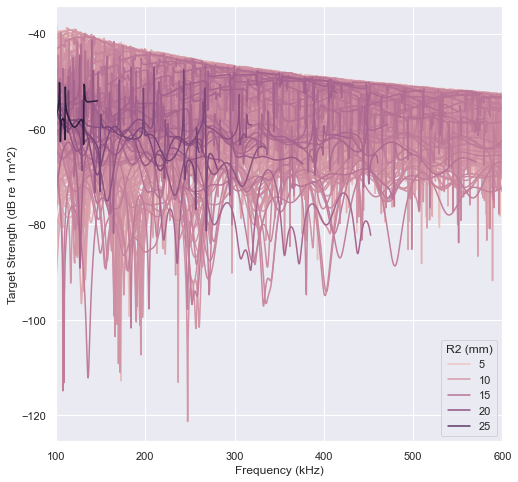

In [101]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_cod',hue='R2 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([100, 600])

(185.0, 383.0)

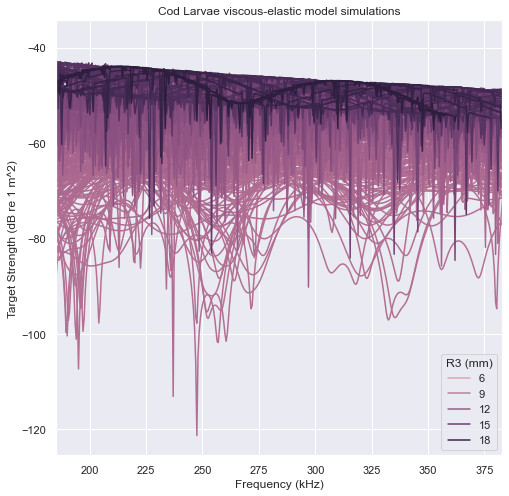

In [102]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_cod',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.title('Cod Larvae viscous-elastic model simulations')
plt.xlim([185, 383])

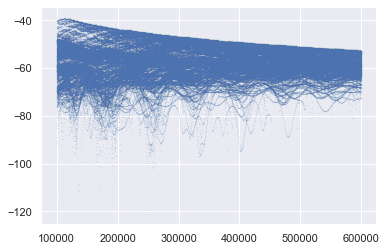

In [103]:
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [107]:
# uncomment when ready.
write_ve('./ve_results/ve_simulations_cod.txt', M_order, params_cod, F_TS_MAT)

In [112]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_cod']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

(100.0, 600.0)

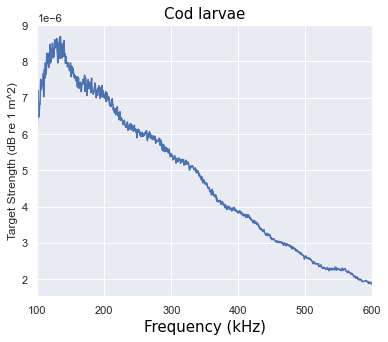

In [115]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='sigbs')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([100, 600])

(100.0, 600.0)

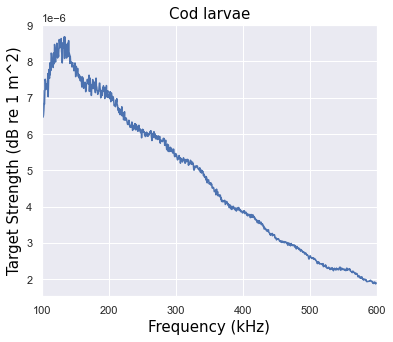

In [125]:
plt.figure(figsize=(6,5))
plt.plot(ve_simdata['freqs'].unique(),mean_bs)
plt.ylabel('Target Strength (dB re 1 m^2)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)
plt.xlim([100, 600])

In [126]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Cod larvae')

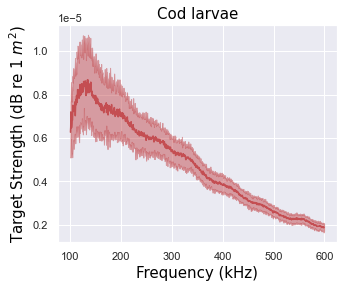

In [130]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Target Strength (dB re 1 $m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Cod larvae', title_font)